# MS-CELEB Face Recognition

## Importing the libraries


In [1]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from mtcnn.mtcnn import MTCNN


# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (192, 192)
SIZE_OF_BATCH = 32
DATA_DIR = pathlib.Path('./data/MS_CELEB_20KnownCat/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


2023-01-15 05:50:59.741097: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-15 05:51:02.133372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:51:02.199803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:51:02.200490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Functions

In [2]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()


def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


def model_evaluation(model, test_images, test_labels, label_dict):
    """Evaluate model performance on test data."""

    (test_loss,
     test_acc,
     test_AUC,
     test_precision,
     test_recall) = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test AUC:', test_AUC)
    print('Test precision:', test_precision)
    print('Test recall:', test_recall)

    predictions = model.predict(test_images)

    confussion_matrix = tf.math.confusion_matrix(
        labels=test_labels.argmax(axis=1),
        predictions=predictions.argmax(axis=1))

    plt.figure(figsize=(10, 20))
    plt.imshow(confussion_matrix, cmap=plt.cm.Blues)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(labels=list(label_dict.values()), ticks=list(label_dict.keys()),
               fontsize=4)
    plt.yticks(labels=list(label_dict.values()),
               ticks=list(label_dict.keys()), fontsize=8)
    plt.grid(False)
    plt.show()


## Importing the data

In [3]:
train_dataset = image_dataset_from_directory(DATA_DIR / 'train',
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR / 'train',
                                                  image_size=SIZE_OF_IMAGES,
                                                  batch_size=SIZE_OF_BATCH,
                                                  label_mode='categorical',
                                                  color_mode='rgb',
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)



Found 1939 files belonging to 20 classes.
Using 1552 files for training.


2023-01-15 05:51:02.487101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 05:51:02.489112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:51:02.489360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:51:02.489566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

Found 1939 files belonging to 20 classes.
Using 387 files for validation.


In [4]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 20)


## Designing the model

In [5]:
# import keras_cv

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.1),

    ]
)


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(SIZE_OF_IMAGES + (3, )))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)

x = layers.Conv2D(filters=32, kernel_size=5,padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

def conv_layer_with_batch_norm(filter_size, kernel_size=3):
    global x
    x = layers.SeparableConv2D(filters=filter_size,
                      kernel_size=kernel_size,
                      use_bias=False,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x



x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = conv_layer_with_batch_norm(64, kernel_size=3)
x = conv_layer_with_batch_norm(64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

residual = x
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(256, 1, strides=(2, 2), use_bias=False)(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

x = conv_layer_with_batch_norm(1024, kernel_size=3)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(20, activation='softmax')(x)

model = keras.Model(inputs=inputs,
                    outputs=outputs,
                    name='Modern_Architecture_ERS')

model.summary()


Model: "Modern_Architecture_ERS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 192, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 192, 192, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 32  2400        ['rescaling

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'Modern_Arch_ERS_20KnwonCat.keras'),
        save_best_only=True,
        monitor="val_loss"),
]

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/100


2023-01-15 05:51:10.899898: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-01-15 05:51:11.945280: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-15 05:51:11.946639: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-15 05:51:11.946678: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-15 05:51:11.946780: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

49/49 [==============================] - 22s 288ms/step - loss: 2.6728 - accuracy: 0.2171 - auc: 0.7459 - precision: 0.3938 - recall: 0.0490 - val_loss: 2.9976 - val_accuracy: 0.0491 - val_auc: 0.4948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
49/49 [==============================] - 12s 253ms/step - loss: 2.2692 - accuracy: 0.3170 - auc: 0.8312 - precision: 0.5381 - recall: 0.1411 - val_loss: 3.0055 - val_accuracy: 0.0388 - val_auc: 0.4919 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
49/49 [==============================] - 12s 251ms/step - loss: 2.0534 - accuracy: 0.3840 - auc: 0.8661 - precision: 0.5913 - recall: 0.2004 - val_loss: 3.0489 - val_accuracy: 0.0491 - val_auc: 0.4639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
49/49 [==============================] - 12s 251ms/step - loss: 1.8181 - accuracy: 0.4265 - auc: 0.8989 - precision: 0.6378 - recall: 0.2564 - val_loss: 3.0760 - val_accuracy: 0.0491 - val_auc: 0.4790 -

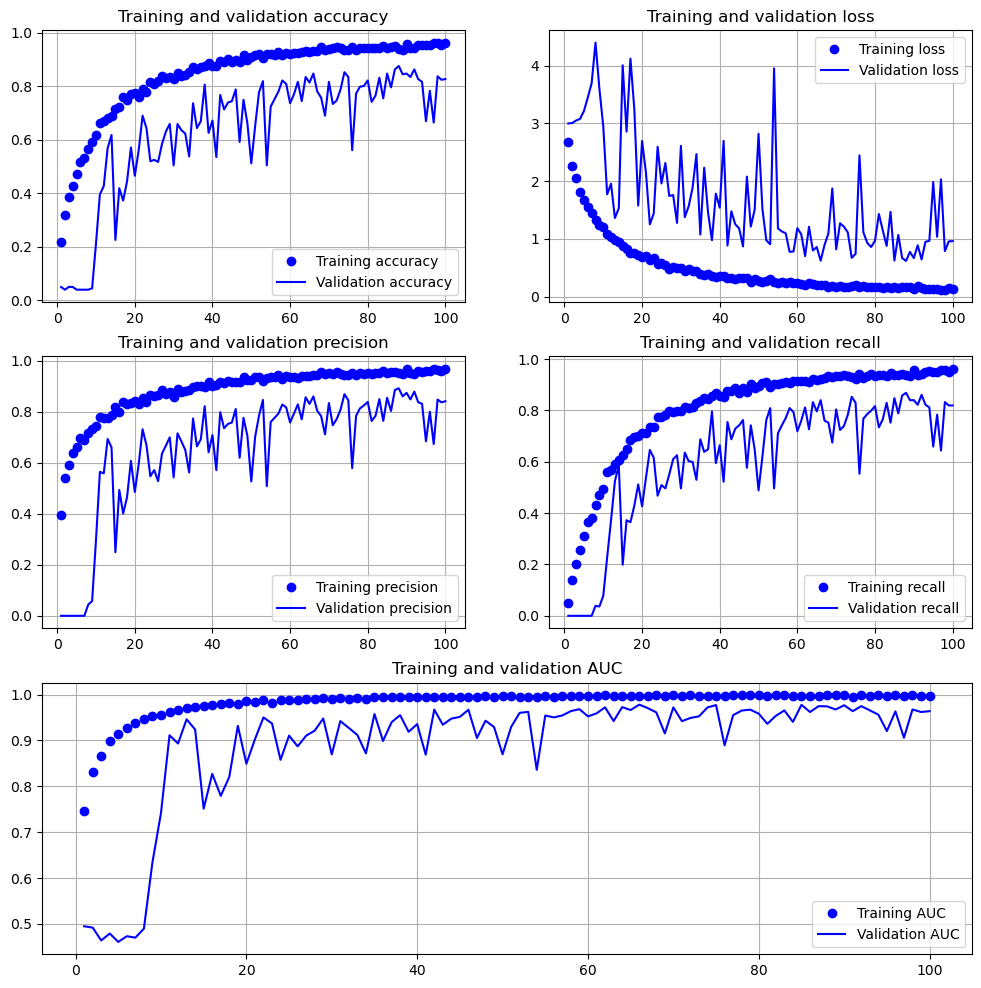

In [8]:
plot_history(history)


In [9]:
show_eval_results(model, validation_dataset)

13/13 [==============================] - 0s 25ms/step - loss: 0.9629 - accuracy: 0.8269 - auc: 0.9638 - precision: 0.8408 - recall: 0.8191
Test loss: 0.963
Test accuracy: 0.827
Test AUC: 0.964
Test Precision: 0.841
Test Recall: 0.819


## Face Detection and Saving the Faces

In [10]:

def extract_face(filename, required_size=SIZE_OF_IMAGES):
    # # load image from file
    pixels = plt.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


In [11]:
for folder in os.listdir(DATA_DIR / 'test'):
    for file in os.listdir(DATA_DIR / 'test' / folder):
        pixels = extract_face(DATA_DIR / 'test' / folder / file)
        os.makedirs(DATA_DIR / 'test_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'test_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 414ms/step


2023-01-15 06:12:06.103483: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:06.103583: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 304ms/step


2023-01-15 06:12:06.479860: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:06.479919: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:06.599847: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:06.600007: W tensorflow/core/common_runtime/bfc_allocato

1/1 [==============================] - 0s 384ms/step


2023-01-15 06:12:12.397793: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:12.397866: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:12.553416: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 06:12:12.553489: W tensorflow/core/common_runtime/bfc_allocato

1/1 [==============================] - 0s 151ms/step


In [12]:
test_dataset_cropped = image_dataset_from_directory(DATA_DIR / 'test_cropped',
                                            image_size=SIZE_OF_IMAGES,
                                            batch_size=SIZE_OF_BATCH,
                                            label_mode='categorical',
                                            color_mode='rgb',
                                            seed=42)

Found 68 files belonging to 20 classes.


In [13]:
show_eval_results(model, test_dataset_cropped)


3/3 [==============================] - 0s 143ms/step - loss: 3.4378 - accuracy: 0.5735 - auc: 0.8447 - precision: 0.5938 - recall: 0.5588
Test loss: 3.438
Test accuracy: 0.574
Test AUC: 0.845
Test Precision: 0.594
Test Recall: 0.559


In [14]:
test_images = []
test_labels = []
for data_batch, labels_batch in test_dataset_cropped:
    for image, label in zip(data_batch, labels_batch):
        test_images.append(image)
        test_labels.append(label)

In [15]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [16]:
label_dict = {v: k for k, v in zip(test_dataset_cropped.class_names, range(20))}

3/3 [==============================] - 0s 18ms/step - loss: 3.4378 - accuracy: 0.5735 - auc: 0.8447 - precision: 0.5938 - recall: 0.5588
Test accuracy: 0.5735294222831726
Test loss: 3.4378180503845215
Test AUC: 0.8446832895278931
Test precision: 0.59375
Test recall: 0.5588235259056091
3/3 [==============================] - 0s 22ms/step


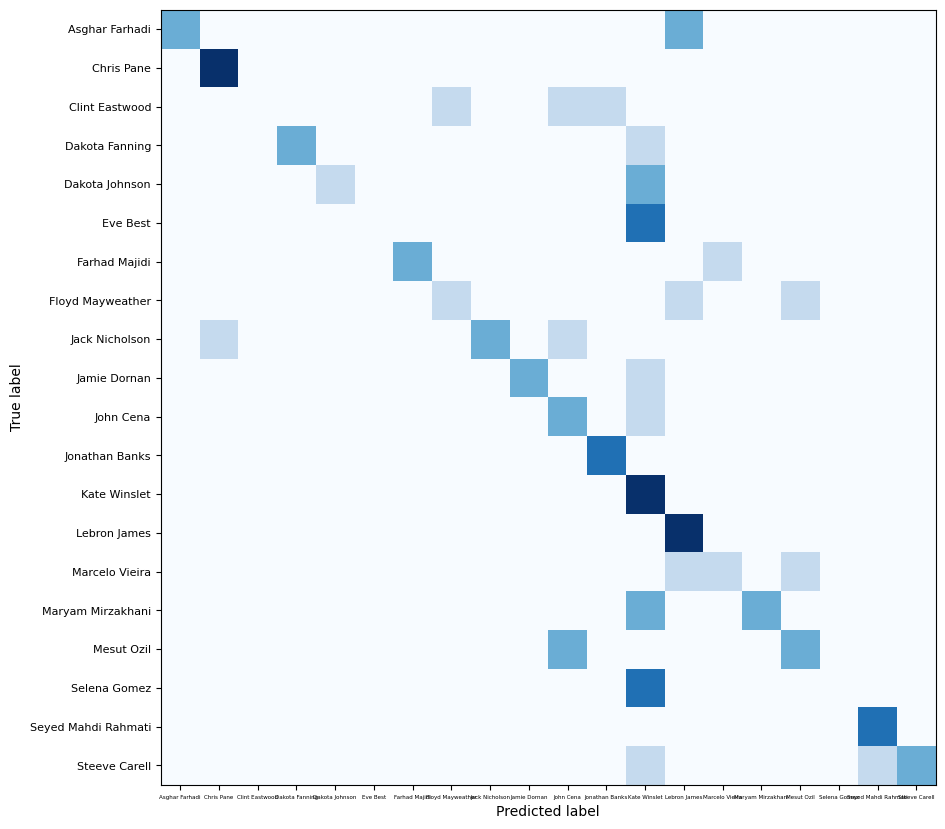

In [17]:
model_evaluation(model, test_images, test_labels, label_dict)